In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [6]:
paths = sorted(glob.glob('*.info.csv'))

all_df = pd.concat([pd.read_csv(p) for p in paths], axis=0, 
                   ignore_index=True)

all_df['safe'] = (all_df['off_target_hits'] == 0)
all_df['broad'] = (all_df['on_target_freq'] >= 0.75)
all_df['effective'] = (all_df['mean_rc'] <= 0.1)

all_df['safe_broad'] = all_df['safe'] & all_df['broad']
all_df['safe_effective'] = all_df['safe'] & all_df['effective']
all_df['safe_broad_effective'] = all_df['safe'] & all_df['effective'] & all_df['broad']

all_df['base'] = all_df['cas'].map(lambda x: x.split('-')[0]).replace('SpRY', 'SpCas9')
all_df['new_name'] = all_df.apply(lambda row: row['base'] + '-' + row['pam_motif'], axis=1)
sa_order = ['SaCas9-NNGRRT', 'SaCas9-NNARRT', 'SaCas9-NNCRRT', 'SaCas9-NNTRRT', 'SaCas9-NNNRRT']
sp_order = ['SpCas9-NGG', 'SpCas9-NGAG', 'SpCas9-NGCG', 'SpCas9-NGA', 'SpCas9-NG', 'SpCas9-NRN']
cpf_order = ['Cpf1-TTTV', 'Cpf1-TTTN', 'Cpf1-TTTR', 'Cpf1-TATV', 'Cpf1-TYCV']

all_df['new_name'] = pd.Categorical(all_df['new_name'], sa_order+['']+sp_order+[' ']+cpf_order)

all_df.head()

,protospacer,chrom,start,hit,strand,mismatches,on_target_freq,off_target_hits,num_lethal,mean_rc,cas,pam_motif,safe,broad,effective,safe_broad,safe_effective,safe_broad_effective,base,new_name
0,ATAAAACCTCCAATTCCCCC,HXB2,2389,TTTGATAAAACCTCCAATTCCCCCTATC,-,0,0.000668,NaN,13,0.148186,Cpf1-TATV,TATV,False,False,False,False,False,False,Cpf1,Cpf1-TATV
1,TACTGTATCATCTGCTCCTG,HXB2,2324,CTAATACTGTATCATCTGCTCCTGTATC,-,0,0.000000,NaN,12,0.150420,Cpf1-TATV,TATV,False,False,False,False,False,False,Cpf1,Cpf1-TATV
2,ATAGGGGGAATTGGAGGTTT,HXB2,2386,AATGATAGGGGGAATTGGAGGTTTTATC,+,0,0.000000,NaN,12,0.137211,Cpf1-TATV,TATV,False,False,False,False,False,False,Cpf1,Cpf1-TATV
3,TAAATAAAATAGTAAGAATG,HXB2,1593,GGATTAAATAAAATAGTAAGAATGTATA,+,0,0.000000,NaN,16,0.088984,Cpf1-TATV,TATV,False,False,True,False,False,False,Cpf1,Cpf1-TATV
4,GTTTGTATGTCTGTTGCTAT,HXB2,4834,TTTAGTTTGTATGTCTGTTGCTATTATG,-,0,0.000000,NaN,20,0.064552,Cpf1-TATV,TATV,False,False,True,False,False,False,Cpf1,Cpf1-TATV


In [17]:
uni_sites

,new_name,start
0,SaCas9-NNGRRT,2
1,SaCas9-NNARRT,1
2,SaCas9-NNCRRT,0
3,SaCas9-NNTRRT,3
4,SaCas9-NNNRRT,9
5,,0
6,SpCas9-NGG,11
7,SpCas9-NGAG,0
8,SpCas9-NGCG,0
9,SpCas9-NGA,7


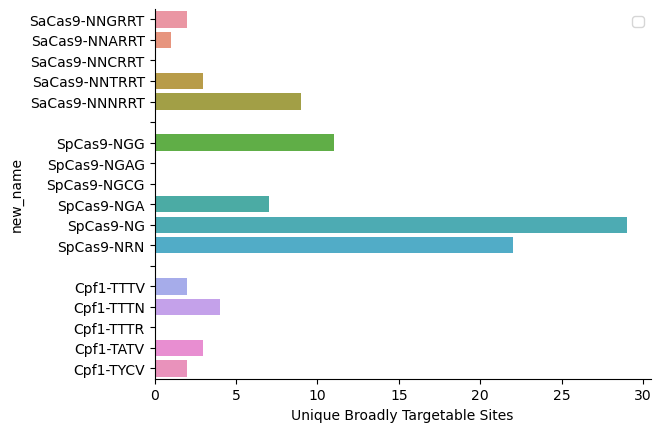

In [16]:
uni_sites = all_df.query('safe_broad_effective').groupby('new_name', as_index=False)['start'].nunique()
ax = sns.barplot(data = uni_sites,
                 orient = 'h',
                 x = 'start',
                 y = 'new_name')
ax.legend([])
#ax.set_ylim(0, 100)
ax.set_xlabel('Unique Broadly Targetable Sites')
sns.despine(ax=ax)
plt.gcf().savefig('unique_site_counts.png', dpi=300)

In [20]:


totals = all_df.groupby(['base', 'pam_motif'])[['safe', 'broad', 'effective', 'safe_broad_effective']].sum()
totals['uniq_sites'] = all_df.query('safe_broad_effective').groupby(['base', 'pam_motif'])['start'].nunique().fillna(0)

totals

safe  broad  effective  safe_broad_effective  uniq_sites
base   pam_motif                                                          
Cpf1   TATV         41     21       6981                     6         3.0
       TTTN        132    105       8573                    19         4.0
       TTTR         48     35       6710                     0         NaN
       TTTV         55     43       7464                    10         2.0
       TYCV        142     50       6337                     2         2.0
SaCas9 NNARRT       43     22       6942                     1         1.0
       NNCRRT       33      2       6043                     0         NaN
       NNGRRT       43     16       7049                     4         2.0
       NNNRRT      236    227       8808                    37         9.0
       NNTRRT       45     17       7102                     6         3.0
SpCas9 NG          365   1291       8879                    41        29.0
       NGA         164    230       7140                    19         7.0
       NGAG         62     22       5033                     0         NaN
       NGCG          6      4       3852                     0         NaN
       NGG         234    213       7726                    28        11.0
       NRN         378   5582      10169                    24        22.0

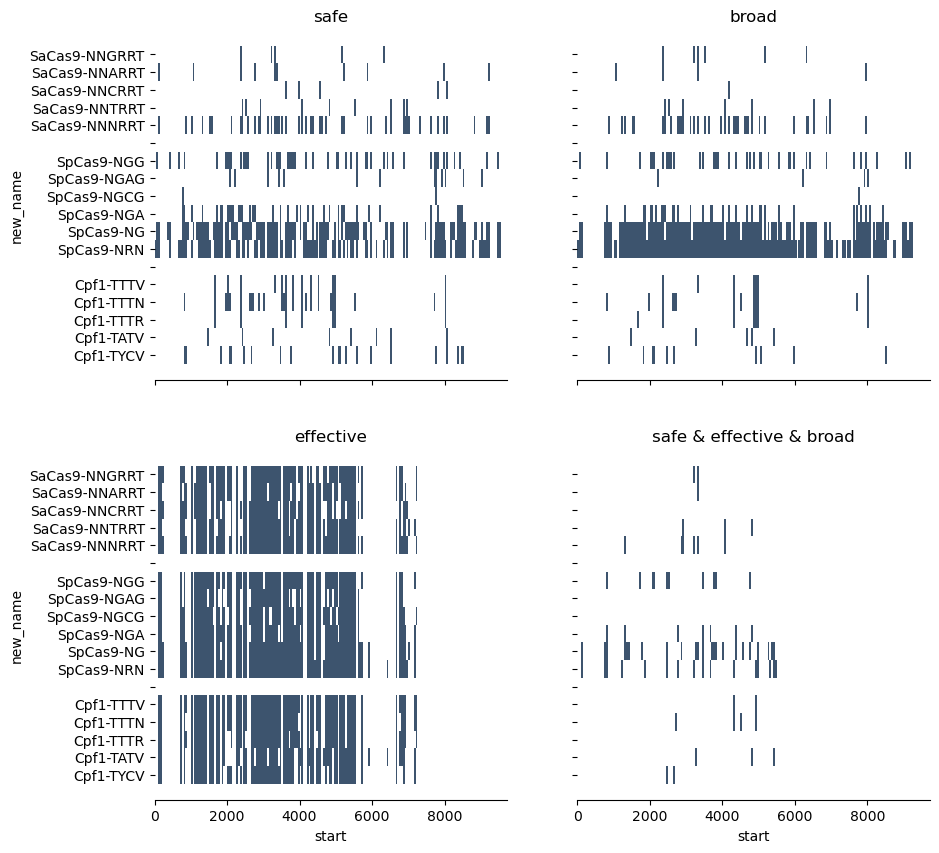

In [8]:
fig, axs = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)

queries = ['safe', 'broad', 'effective', 'safe & effective & broad']

for q, ax in zip(queries, axs.flatten()):
    
    sns.histplot(data = all_df.query(q),
                 x = 'start', y = 'new_name', 
                 bins = (np.arange(0, 9718, 50), None),
                 vmin = 0, vmax=1, stat='count', ax=ax)
    ax.set_title(q)
    ax.set_xlim(0, 9717)
    sns.despine(ax=ax, left=True)
    
fig.savefig('variant_map.png', dpi=300)